In [15]:
# imports
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE # pra que essa linha?
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_hub as hub

In [5]:
# baixar as imagens: origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 118s 1us/step


In [6]:
# contagem da quantidade de imagem contida neste arquivo 
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [8]:
# nomes das flores contidas neste exemplo
CLASS_NAMES = np.array([i.name for i in data_dir.glob('*') if i.name != 'LICENSE.txt'])
CLASS_NAMES

array(['roses', 'tulips', 'daisy', 'sunflowers', 'dandelion'],
      dtype='<U10')

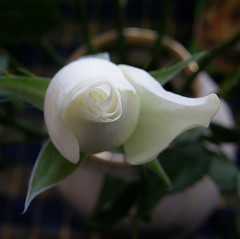

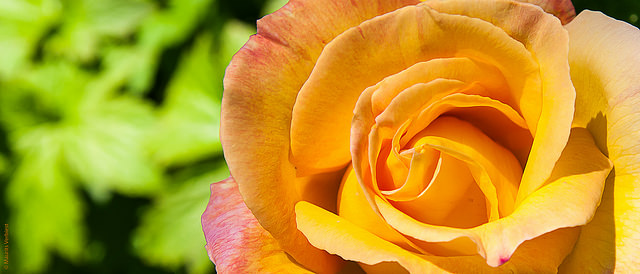

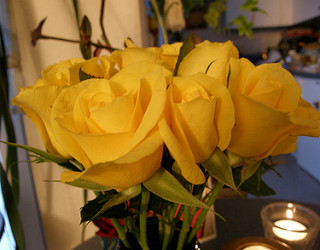

In [9]:
# exemplo de tres imagens de rosas, as imagens tem tamanhos diferentes
roses = list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

https://www.tensorflow.org/hub/tutorials/tf2_image_retraining?hl=pt

In [10]:
# daqui para baixo o codigo foi tirado da URL acima
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [12]:
# configurando o conjunto de dados As entradas são redimensionadas adequadamente para o módulo selecionado. O aumento do conjunto de dados (ou seja, distorções aleatórias de uma imagem cada vez que ela é lida) melhora o treinamento, esp. durante o ajuste fino.
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [16]:
do_fine_tuning = True 
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [19]:
# Treinando o modelo
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 383s 4s/step - loss: 0.9622 - accuracy: 0.7812 - val_loss: 1.5139 - val_accuracy: 0.7102
Epoch 2/5
91/91 [==============================] - 314s 3s/step - loss: 0.7172 - accuracy: 0.9061 - val_loss: 0.7488 - val_accuracy: 0.8949
Epoch 3/5
91/91 [==============================] - 306s 3s/step - loss: 0.6705 - accuracy: 0.9226 - val_loss: 0.7173 - val_accuracy: 0.9134
Epoch 4/5
91/91 [==============================] - 319s 4s/step - loss: 0.6289 - accuracy: 0.9450 - val_loss: 0.6712 - val_accuracy: 0.9261
Epoch 5/5
91/91 [==============================] - 400s 4s/step - loss: 0.5926 - accuracy: 0.9598 - val_loss: 0.6759 - val_accuracy: 0.9176


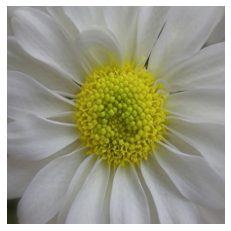

True label: daisy
Predicted label: daisy


In [20]:
# predizendo um exemplo de flor
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))